In [ ]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import io
import sys
import tempfile
import tqdm
from base64 import b64decode, b64encode

import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# Download model from TF Hub and check out inference code from GitHub
!wget -q -O movenet_thunder.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
!git clone https://github.com/tensorflow/examples.git
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)


Cloning into 'examples'...
remote: Enumerating objects: 21931, done.
remote: Counting objects: 100% (591/591), done.
remote: Compressing objects: 100% (343/343), done.
remote: Total 21931 (delta 234), reused 463 (delta 170), pack-reused 21340
Receiving objects: 100% (21931/21931), 37.46 MiB | 15.23 MiB/s, done.
Resolving deltas: 100% (11990/11990), done.


In [ ]:
# loading the model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

In [ ]:
#  returns skeleton of the person detected by movenet
# copied from tensorflow movenets
def detect(input_tensor, inference_count=3):
  image_height, image_width, channel = input_tensor.shape

  # Detect pose using the full input image
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [ ]:
# return the image with a skeleton drawn on the human body
# copied from tensorflow movenets
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)

  if close_figure:
    plt.close(fig)

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [ ]:
# finding the angles at different joints
def cal_angle(a,b,c):
    a = np.array(a)
    b = np.array(b)
    c = np.array(c)
#    tan theta = slope -- slope = tan inverse theta
#    difference btw to slopes to find the angle between the two lines(joints)
    angle = np.abs((np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])) * 180.0/np.pi)
    if angle >  180.0:
        angle = 360.0 - angle
        
    return angle

In [ ]:
# body_parts = []
# body_coordinates = []
# i = 0
# for keypoints in person.keypoints:
#     x_val = keypoints.coordinate.x
#     y_val = keypoints.coordinate.y
#     i = i+1
#     pos = [x_val, y_val]
#     a = str(keypoints[0])
#     body_parts.append(str(a.split('.')[-1]))
#     body_coordinates.append(pos)

# L1 = body_parts
# L2 = body_coordinates
# bp_coordinates = dict(zip(L1,L2))
# bp_coordinates

In [ ]:
# body_angles = []
# parts = [['NOSE', 'NOSE' , 'NOSE'], ['LEFT_EYE', 'LEFT_EYE', 'LEFT_EYE'], ['RIGHT_EYE', 'RIGHT_EYE', 'RIGHT_EYE'], ['LEFT_EAR', 'LEFT_EAR', 'LEFT_EAR'], ['RIGHT_EAR', 'RIGHT_EAR', 'RIGHT_EAR'], ['LEFT_ELBOW', 'LEFT_SHOULDER', 'LEFT_HIP'], ['RIGHT_ELBOW', 'RIGHT_SHOULDER', 'RIGHT_HIP'], ['LEFT_WRIST', 'LEFT_ELBOW', 'LEFT_SHOULDER'], ['RIGHT_WRIST', 'RIGHT_ELBOW', 'RIGHT_SHOULDER'], ['LEFT_WRIST', 'LEFT_WRIST', 'LEFT_WRIST'], ['RIGHT_WRIST', 'RIGHT_WRIST', 'RIGHT_WRIST'], ['LEFT_SHOULDER', 'LEFT_HIP', 'LEFT_KNEE'], ['RIGHT_SHOULDER', 'RIGHT_HIP', 'RIGHT_KNEE'], ['LEFT_HIP', 'LEFT_KNEE', 'LEFT_ANKLE'], ['RIGHT_HIP', 'RIGHT_KNEE', 'RIGHT_ANKLE'], ['LEFT_ANKLE', 'LEFT_ANKLE', 'LEFT_ANKLE'], ['RIGHT_ANKLE', 'RIGHT_ANKLE', 'RIGHT_ANKLE']]
# for pts in parts:
#     part_1 = bp_coordinates[pts[0]]
#     part_2 = bp_coordinates[pts[1]]
#     part_3 = bp_coordinates[pts[2]]
#     body_angles.append(cal_angle(part_1, part_2, part_3))

# print(body_angles)

In [ ]:
# person = detect(image)
# for index, keypoints in enumerate(person.keypoints):
#   print(keypoints , index)

In [ ]:
# detecte pose landmarks and corresponding angles and save them to csv
class MoveNetPreprocessor(object):
  # preprocess pose sample images for classification
  def __init__(self, images_in_folder, images_out_folder, csvs_out_path):
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    # Create a temp dir to store the pose CSVs per class
    self._csvs_out_folder_per_class = tempfile.mkdtemp()

    # Get list of pose classes and print image statistics
    # making list of poses by using the folder name
    self._pose_class_names = sorted([n for n in os.listdir(self._images_in_folder) if not n.startswith('.')])

  def process(self, per_pose_class_limit= None, detection_threshold=0.6):
    """Preprocesses images in the given folder.
    Args:
      per_pose_class_limit: Number of images to load. As preprocessing usually
        takes time, this parameter can be specified to make the reduce of the
        dataset for testing.
      detection_threshold: Only keep images with all landmark confidence score
        above this threshold.
    """
    # Loop through the classes and preprocess its images
    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)

      # defining paths for the pose class
      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class, pose_class_name + '.csv')
      # making output folder if not exists
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)

      # Detect landmarks in each image and write it to a CSV file
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, delimiter = ',', quoting = csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted([n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          # iterating to all images till the max pose limit
          image_names = image_names[:per_pose_class_limit]
        # image counter
        valid_image_count = 0
        # Detect pose landmarks from each image
        # tqdm make the progress bars
        for image_name in tqdm.tqdm(image_names):
          # defining the path of the image
          image_path = os.path.join(images_in_folder, image_name)
          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape

          # Skip images that isn't RGB because Movenet requires RGB images
          if channel != 3:
            self._messages.append('Skipped ' + image_path + '. Image isn\'t in RGB format.')
            continue
          #  using detect function to make the skeleton of the person in the following image
          person = detect(image)

          # forming a dictionary of body parts with their corresponding coordinates
          body_parts = []
          body_coordinates = []
          i = 0
          for keypoints in person.keypoints:
              x_val = keypoints.coordinate.x
              y_val = keypoints.coordinate.y
              i = i+1
              pos = [x_val, y_val]
              a = str(keypoints[0])
              body_parts.append(str(a.split('.')[-1]))
              body_coordinates.append(pos)

          L1 = body_parts
          L2 = body_coordinates
          bp_coordinates = dict(zip(L1,L2))
          # bp_coordinates

          # forming an array of angles for every joint detected to add it to csv data
          body_angles = []
          parts = [['NOSE', 'NOSE' , 'NOSE'], ['LEFT_EYE', 'LEFT_EYE', 'LEFT_EYE'], ['RIGHT_EYE', 'RIGHT_EYE', 'RIGHT_EYE'], ['LEFT_EAR', 'LEFT_EAR', 'LEFT_EAR'], ['RIGHT_EAR', 'RIGHT_EAR', 'RIGHT_EAR'], ['LEFT_ELBOW', 'LEFT_SHOULDER', 'LEFT_HIP'], ['RIGHT_ELBOW', 'RIGHT_SHOULDER', 'RIGHT_HIP'], ['LEFT_WRIST', 'LEFT_ELBOW', 'LEFT_SHOULDER'], ['RIGHT_WRIST', 'RIGHT_ELBOW', 'RIGHT_SHOULDER'], ['LEFT_WRIST', 'LEFT_WRIST', 'LEFT_WRIST'], ['RIGHT_WRIST', 'RIGHT_WRIST', 'RIGHT_WRIST'], ['LEFT_SHOULDER', 'LEFT_HIP', 'LEFT_KNEE'], ['RIGHT_SHOULDER', 'RIGHT_HIP', 'RIGHT_KNEE'], ['LEFT_HIP', 'LEFT_KNEE', 'LEFT_ANKLE'], ['RIGHT_HIP', 'RIGHT_KNEE', 'RIGHT_ANKLE'], ['LEFT_ANKLE', 'LEFT_ANKLE', 'LEFT_ANKLE'], ['RIGHT_ANKLE', 'RIGHT_ANKLE', 'RIGHT_ANKLE']]
          for pts in parts:
              part_1 = bp_coordinates[pts[0]]
              part_2 = bp_coordinates[pts[1]]
              part_3 = bp_coordinates[pts[2]]
              body_angles.append(cal_angle(part_1, part_2, part_3))

          # print(body_angles)
          # Save landmarks if all landmarks were detected
          # saving the landmarks that have detection score greater than the set threshold
          min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +'. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

          # Draw the prediction result on top of the image for debugging later
          # Drawing the landmarks on the image that satisfy the threshold factor by using the above function
          output_overlay = draw_prediction_on_image(image.numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)

          # converting RGB to BGR so that it can be used in opencv
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          # saving the output images having filtered landmarks
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)

          # Get landmarks and scale it to the same size as the input image
          # [x, y, score]  for every landmark
          pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, body_angles[index], keypoint.score] for index, keypoint in enumerate(person.keypoints)], dtype=np.float32)

          # saving the coordinates with the image nape in csv file
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError('No valid images found for the "{}" class.'.format(pose_class_name))

    # Print the error message collected during preprocessing.
    print('\n'.join(self._messages))

    # Combine all per-class CSVs into a single output file
    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names

  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      # creating csv path for each pose type
      csv_out_path = os.path.join(self._csvs_out_folder_per_class, class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)

      # Add the labels
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

      # Append the folder name to the filename column (first column)
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        # For the first class, assign its data to the total dataframe
        total_df = per_class_df
      else:
        # Concatenate each class's data into the total dataframe
        total_df = pd.concat([total_df, per_class_df], axis=0)

    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}

    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [ ]:
# NOTE:
# IT WILL TAKE TENSORS AS INPUT

--2022-08-05 06:40:15--  https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.37.244, 172.64.150.12, 2606:4700:4400::ac40:960c, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.37.244|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17685 (17K) [image/jpeg]
Saving to: ‘/tmp/image.jpeg’

/tmp/image.jpeg     100%[===================>]  17.27K  --.-KB/s    in 0s      

2022-08-05 06:40:15 (87.3 MB/s) - ‘/tmp/image.jpeg’ saved [17685/17685]



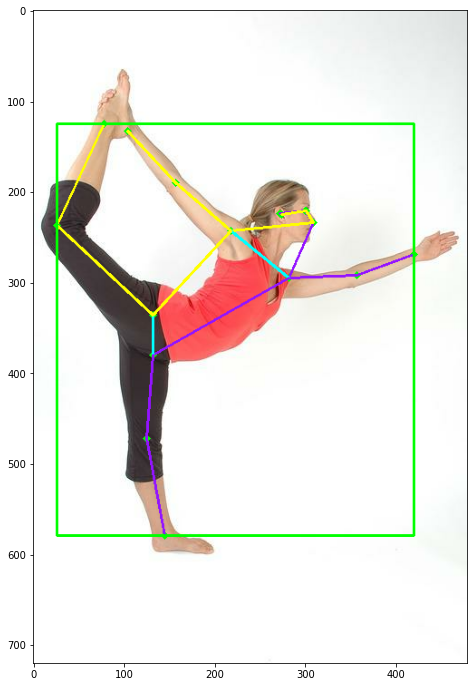

In [ ]:
# printing landmarks on the image
test_image_url = "https://cdn.pixabay.com/photo/2017/03/03/17/30/yoga-2114512_960_720.jpg"
!wget -O /tmp/image.jpeg {test_image_url}

if len(test_image_url):
  image = tf.io.read_file('/tmp/image.jpeg')
  image = tf.io.decode_jpeg(image)
  person = detect(image)
  t = draw_prediction_on_image(image.numpy(), person, crop_region=None,close_figure=False, keep_input_size=True)

loading the dataset

In [ ]:
!pip install kaggle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d niharika41298/yoga-poses-dataset

 92% 265M/288M [00:12<00:01, 16.9MB/s]
100% 288M/288M [00:12<00:00, 24.3MB/s]


In [ ]:
!unzip yoga-poses-dataset

Archive:  yoga-poses-dataset.zip
  inflating: DATASET/TEST/downdog/00000000.jpg  
  inflating: DATASET/TEST/downdog/00000001.JPG  
  inflating: DATASET/TEST/downdog/00000002.jpg  
  inflating: DATASET/TEST/downdog/00000003.jpg  
  inflating: DATASET/TEST/downdog/00000004.jpg  
  inflating: DATASET/TEST/downdog/00000005.jpg  
  inflating: DATASET/TEST/downdog/00000006.jpg  
  inflating: DATASET/TEST/downdog/00000007.jpg  
  inflating: DATASET/TEST/downdog/00000008.jpg  
  inflating: DATASET/TEST/downdog/00000009.jpg  
  inflating: DATASET/TEST/downdog/00000010.png  
  inflating: DATASET/TEST/downdog/00000011.jpg  
  inflating: DATASET/TEST/downdog/00000012.jpg  
  inflating: DATASET/TEST/downdog/00000013.jpg  
  inflating: DATASET/TEST/downdog/00000014.jpg  
  inflating: DATASET/TEST/downdog/00000016.jpg  
  inflating: DATASET/TEST/downdog/00000017.png  
  inflating: DATASET/TEST/downdog/00000018.jpg  
  inflating: DATASET/TEST/downdog/00000019.jpg  
  inflating: DATASET/TEST/downdog/00

In [ ]:
os.listdir('./DATASET')

['TRAIN', 'TEST']

In [ ]:
import shutil


In [ ]:
import os
dataset_dir = './DATASET/TRAIN'
detection_classes = []
for entry in os.scandir(dataset_dir):
  l = entry.path
  detection_classes.append(l.split('/')[-1])

print(detection_classes)

['warrior2', 'tree', 'goddess', 'plank', 'downdog']


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = './DATASET/TRAIN'
test_dir = './DATASET/TEST'

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, zoom_range = 0.2)
train_dataset = train_datagen.flow_from_directory(train_dir, classes = detection_classes, shuffle=True, batch_size= 12, target_size=(120, 120))

test_datagen = ImageDataGenerator(rescale = 1./255, horizontal_flip = True, zoom_range = 0.2)
test_dataset = test_datagen.flow_from_directory(test_dir, classes = detection_classes, shuffle=True, batch_size= 12, target_size=(120, 120))

Found 1081 images belonging to 5 classes.
Found 470 images belonging to 5 classes.


In [ ]:
#  preprocessing train dataset

images_in_train_folder = './DATASET/TRAIN'
images_out_train_folder = './yoga_train_detect'
csv_out_train_path = './yoga_train_csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csv_out_train_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing downdog
  2%|▏         | 5/223 [00:16<12:30,  3.44s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 223/223 [12:11<00:00,  3.28s/it]
Preprocessing goddess
 69%|██████▉   | 125/180 [06:34<02:56,  3.20s/it]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 180/180 [09:35<00:00,  3.20s/it]
Preprocessing plank
100%|██████████|

Skipped ./DATASET/TRAIN/downdog/00000128.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000129.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000130.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000131.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000132.png. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000134.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000135.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000137.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000139.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000140.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000142.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/downdog/00000143.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TRAIN/down

In [ ]:
#  preprocessing test dataset

images_in_test_folder = './DATASET/TEST/' 
images_out_test_folder = './yoga_test_detect'
csv_out_test_path = './yoga_test_csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csv_out_test_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing downdog
  2%|▏         | 2/97 [00:06<05:09,  3.26s/it]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:123: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
100%|██████████| 97/97 [05:00<00:00,  3.10s/it]
Preprocessing goddess
100%|██████████| 80/80 [04:14<00:00,  3.18s/it]
Preprocessing plank
100%|██████████| 115/115 [06:02<00:00,  3.15s/it]
Preprocessing tree
 86%|████████▌ | 59/69 [03:11<00:33,  3.33s/it]/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double

Skipped ./DATASET/TEST/downdog/00000000.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000001.JPG. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000003.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000004.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000008.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000010.png. Image isn't in RGB format.
Skipped ./DATASET/TEST/downdog/00000011.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000012.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000013.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000017.png. Image isn't in RGB format.
Skipped ./DATASET/TEST/downdog/00000018.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000019.jpg. No pose was confidentlly detected.
Skipped ./DATASET/TEST/downdog/00000020.jpg. No pose was

In [ ]:
# copied from tensorflow
def load_pose_landmarks(csv_path):
  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [ ]:
X, y, class_names, _ = load_pose_landmarks(csv_out_train_path)

In [ ]:
print(y)   # y data
print(X)   # X data
print(class_names)  # labels

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
     NOSE_x  NOSE_y  NOSE_score  LEFT_EYE_x  LEFT_EYE_y  LEFT_EYE_score  \
0     588.0   563.0         0.0    0.776305       571.0           568.0   
1     443.0   473.0         0.0    0.846087       423.0           483.0   
2     460.0   754.0         0.0    0.743380       446.0           758.0   
3     460.0   754.0         0.0    0.743380       446.0           758.0   
4     380.0   304.0         0.0    0.788868       369.0           309.0   
..      ...     ...         ...         ...         ...             ...   
388   366.0   143.0         0.0    0.812638       373.0           136.0   
389   669.0    93.0         0.0    0.713464       685.0            79.0   
390   283.0   163.0         0.0    0.636360       285.0           158.0   
391   208.0   380.0         0.0    0.718539       214.0           375.0   
392   130.0    38.0         0.0    0.874884       135.0      

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.1)
X_test, y_test, _, df_test = load_pose_landmarks(csv_out_test_path)

In [ ]:
print(X_train)

     NOSE_x  NOSE_y  NOSE_score  LEFT_EYE_x  LEFT_EYE_y  LEFT_EYE_score  \
136   169.0   336.0         0.0    0.794186       160.0           338.0   
100  2361.0  1326.0         0.0    0.834509      2401.0          1275.0   
331   293.0    51.0         0.0    0.604942       301.0            44.0   
345   636.0    97.0         0.0    0.847827       626.0            84.0   
194   914.0   348.0         0.0    0.826043       931.0           370.0   
..      ...     ...         ...         ...         ...             ...   
109   361.0   122.0         0.0    0.898943       368.0           115.0   
77     40.0    17.0         0.0    0.892719        42.0            16.0   
338   222.0   244.0         0.0    0.777239       231.0           235.0   
128   358.0   126.0         0.0    0.867903       367.0           117.0   
304   716.0   170.0         0.0    0.751728       727.0           148.0   

     RIGHT_EYE_x  RIGHT_EYE_y  RIGHT_EYE_score  LEFT_EAR_x  ...          59  \
136          0.0    

In [ ]:
# copied from tensorflow movenets
# Moving the pose center to the origin.
# Scaling the pose so that the pose size becomes 1
# Flattening these coordinates into a feature vector


def get_center_point(landmarks, left_bodypart, right_bodypart):
  """Calculates the center point of the two given landmarks."""

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  """Calculates pose size.

  It is the maximum of two values:
    * Torso size multiplied by `torso_size_multiplier`
    * Maximum distance from pose center to any pose landmark
  """
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  """Normalizes the landmarks translation by moving the pose center to (0,0) and
  scaling it to a constant pose size.
  """
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 4)
  reshaped_inputs = keras.layers.Reshape((17, 4))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
  print(landmarks)
  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM


In [ ]:
X_train.shape

(353, 68)

In [ ]:
y_train.shape

(353, 5)

In [ ]:
inputs = tf.keras.Input(shape=(68))
embedding = landmarks_to_embedding(inputs)

layer = Dense(256, activation= 'relu')(embedding)
layer = Dropout(0.5)(layer)
layer = Dense(128, activation= 'relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(64, activation = 'relu')(layer)
outputs = Dense(len(class_names), activation="softmax")(layer)

yoga_pose_model = keras.Model(inputs, outputs)
yoga_pose_model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 2), dtype=tf.float32, name=None), name='tf.math.truediv/truediv:0', description="created by layer 'tf.math.truediv'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 68)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 4)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                         

In [ ]:
# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

In [ ]:
yoga_pose_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Start training
history = yoga_pose_model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint])

Epoch 1/200
23/23 [==============================] - ETA: 0s - loss: 1.5534 - accuracy: 0.3031
Epoch 1: val_accuracy improved from -inf to 0.37500, saving model to weights.best.hdf5
23/23 [==============================] - 4s 21ms/step - loss: 1.5534 - accuracy: 0.3031 - val_loss: 1.4506 - val_accuracy: 0.3750
Epoch 2/200
17/23 [=====================>........] - ETA: 0s - loss: 1.4215 - accuracy: 0.3713
Epoch 2: val_accuracy improved from 0.37500 to 0.42500, saving model to weights.best.hdf5
23/23 [==============================] - 0s 6ms/step - loss: 1.3903 - accuracy: 0.3796 - val_loss: 1.2584 - val_accuracy: 0.4250
Epoch 3/200
16/23 [===================>..........] - ETA: 0s - loss: 1.2375 - accuracy: 0.4570
Epoch 3: val_accuracy improved from 0.42500 to 0.47500, saving model to weights.best.hdf5
23/23 [==============================] - 0s 7ms/step - loss: 1.2156 - accuracy: 0.4618 - val_loss: 1.0345 - val_accuracy: 0.4750
Epoch 4/200
17/23 [=====================>........] - ETA: 0s

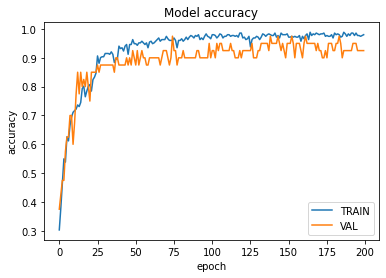

In [ ]:
# plotting the accuracy of the model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

SAVING OUR MODEL TO USE IT IN TENSORFLOW.JS

In [ ]:
yoga_pose_model.save('anuj_model.h5')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(yoga_pose_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

print('Model size: %dKB' % (len(tflite_model) / 1024))

with open('pose_classifier.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzf0qsmpl/assets


Model size: 64KB


Confusion matrix, without normalization

Classification Report:
               precision    recall  f1-score   support

     downdog       1.00      0.85      0.92        26
     goddess       0.89      0.89      0.89        54
       plank       0.94      1.00      0.97        61
        tree       1.00      1.00      1.00        26
    warrior2       0.93      0.93      0.93        84

    accuracy                           0.94       251
   macro avg       0.95      0.93      0.94       251
weighted avg       0.94      0.94      0.94       251



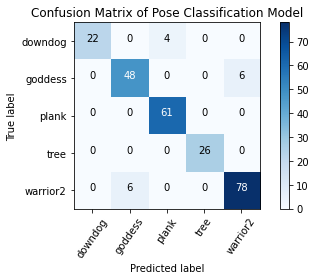

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = yoga_pose_model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [ ]:
! pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 40 kB 4.9 MB/s 
     |████████████████████████████████| 1.0 MB 34.8 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 1.6 MB 58.0 MB/s 
     |████████████████████████████████| 511.7 MB 4.7 kB/s 
     |████████████████████████████████| 5.8 MB 75.9 MB/s 
     |████████████████████████████████| 438 kB 78.8 MB/s 
     |████████████████████████████████| 5.8 MB 59.4 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempti

In [ ]:
! pip install tf-estimator-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 439 kB 37.7 MB/s 


In [ ]:
! pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from keras.models import model_from_json
model_in_json = yoga_pose_model.to_json()
with open('anuj_yoga_model.json', 'w') as json_file:
  json_file.write(model_in_json)

SHOW PREDICTIONS

In [ ]:
# image = tf.io.read_file('/content/pred/test_downdog.JPG')
# image = tf.io.decode_jpeg(image)
# person = detect(image)
# t = draw_prediction_on_image(image.numpy(), person, crop_region=None,close_figure=False, keep_input_size=True)

In [ ]:
# image_path = '/content/pred/test_goodess.JPG'
# try:
#   image = tf.io.read_file(image_path)
#   image = tf.io.decode_jpeg(image)
# except:
#   print('Skipped ' + image_path + '. Invalid image.')
# else:
#   image = tf.io.read_file(image_path)
#   image = tf.io.decode_jpeg(image)
#   image_height, image_width, channel = image.shape

# # Skip images that isn't RGB because Movenet requires RGB images
# if channel != 3:
#   print('Skipped ' + image_path + '. Image isn\'t in RGB format.')
# #  using detect function to make the skeleton of the person in the following image
# person = detect(image)
# detection_threshold = 0.5
# valid_image_count = 0
# # forming a dictionary of body parts with their corresponding coordinates
# body_parts = []
# body_coordinates = []
# i = 0
# for keypoints in person.keypoints:
#     x_val = keypoints.coordinate.x
#     y_val = keypoints.coordinate.y
#     i = i+1
#     pos = [x_val, y_val]
#     a = str(keypoints[0])
#     body_parts.append(str(a.split('.')[-1]))
#     body_coordinates.append(pos)

# L1 = body_parts
# L2 = body_coordinates
# bp_coordinates = dict(zip(L1,L2))
# # bp_coordinates

# # forming an array of angles for every joint detected to add it to csv data
# body_angles = []
# parts = [['NOSE', 'NOSE' , 'NOSE'], ['LEFT_EYE', 'LEFT_EYE', 'LEFT_EYE'], ['RIGHT_EYE', 'RIGHT_EYE', 'RIGHT_EYE'], ['LEFT_EAR', 'LEFT_EAR', 'LEFT_EAR'], ['RIGHT_EAR', 'RIGHT_EAR', 'RIGHT_EAR'], ['LEFT_ELBOW', 'LEFT_SHOULDER', 'LEFT_HIP'], ['RIGHT_ELBOW', 'RIGHT_SHOULDER', 'RIGHT_HIP'], ['LEFT_WRIST', 'LEFT_ELBOW', 'LEFT_SHOULDER'], ['RIGHT_WRIST', 'RIGHT_ELBOW', 'RIGHT_SHOULDER'], ['LEFT_WRIST', 'LEFT_WRIST', 'LEFT_WRIST'], ['RIGHT_WRIST', 'RIGHT_WRIST', 'RIGHT_WRIST'], ['LEFT_SHOULDER', 'LEFT_HIP', 'LEFT_KNEE'], ['RIGHT_SHOULDER', 'RIGHT_HIP', 'RIGHT_KNEE'], ['LEFT_HIP', 'LEFT_KNEE', 'LEFT_ANKLE'], ['RIGHT_HIP', 'RIGHT_KNEE', 'RIGHT_ANKLE'], ['LEFT_ANKLE', 'LEFT_ANKLE', 'LEFT_ANKLE'], ['RIGHT_ANKLE', 'RIGHT_ANKLE', 'RIGHT_ANKLE']]
# for pts in parts:
#     part_1 = bp_coordinates[pts[0]]
#     part_2 = bp_coordinates[pts[1]]
#     part_3 = bp_coordinates[pts[2]]
#     body_angles.append(cal_angle(part_1, part_2, part_3))

# # Save landmarks if all landmarks were detected
# # saving the landmarks that have detection score greater than the set threshold
# min_landmark_score = min([keypoint.score for keypoint in person.keypoints])
# should_keep_image = min_landmark_score >= detection_threshold
# if not should_keep_image:
#   print('Skipped ' + image_path +'. No pose was confidentlly detected.')

# valid_image_count += 1

# # Draw the prediction result on top of the image for debugging later
# # Drawing the landmarks on the image that satisfy the threshold factor by using the above function
# output_overlay = draw_prediction_on_image(image.numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)

# # converting RGB to BGR so that it can be used in opencv
# output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)

# # Get landmarks and scale it to the same size as the input image
# # [x, y, score]  for every landmark
# pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, body_angles[index], keypoint.score,] for index, keypoint in enumerate(person.keypoints)], dtype=np.float32)

# # saving the coordinates with the image nape in csv file
# coordinates = pose_landmarks.flatten().astype(np.str).tolist()

In [ ]:
# plt.imshow(output_frame)

In [ ]:
# input = pose_landmarks.reshape(1, 68)
# input_df = pd. DataFrame(input, columns=['NOSE_x', 'NOSE_y', 'NOSE_score', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_score', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_score', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_score', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_score', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_score', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_score', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_score', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_score', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_score', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_score', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_score', 'RIGHT_HIP_x', 'RIGHT_HIP_y', 'RIGHT_HIP_score', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_score', 'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_score', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_ANKLE_score', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y', 'RIGHT_ANKLE_score', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68']
# ) 

In [ ]:
# p = yoga_pose_model.predict(input_df)
# print('predicted_class is ', class_names[np.argmax(p)])

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


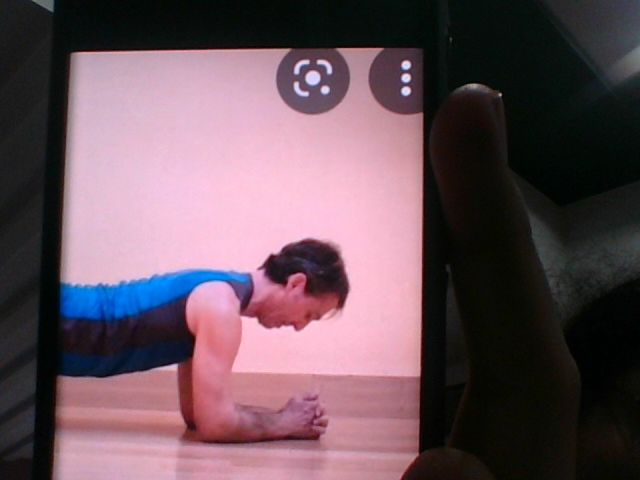

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
image_path = filename
try:
  image = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image)
except:
  print('Skipped ' + image_path + '. Invalid image.')
else:
  image = tf.io.read_file(image_path)
  image = tf.io.decode_jpeg(image)
  image_height, image_width, channel = image.shape

# Skip images that isn't RGB because Movenet requires RGB images
if channel != 3:
  print('Skipped ' + image_path + '. Image isn\'t in RGB format.')
#  using detect function to make the skeleton of the person in the following image
person = detect(image)
detection_threshold = 0.5
valid_image_count = 0
count = 0
# forming a dictionary of body parts with their corresponding coordinates
body_parts = []
body_coordinates = []
i = 0
for keypoints in person.keypoints:
    x_val = keypoints.coordinate.x
    y_val = keypoints.coordinate.y
    i = i+1
    pos = [x_val, y_val]
    a = str(keypoints[0])
    body_parts.append(str(a.split('.')[-1]))
    body_coordinates.append(pos)

L1 = body_parts
L2 = body_coordinates
bp_coordinates = dict(zip(L1,L2))
# bp_coordinates

# forming an array of angles for every joint detected to add it to csv data
body_angles = []
parts = [['NOSE', 'NOSE' , 'NOSE'], ['LEFT_EYE', 'LEFT_EYE', 'LEFT_EYE'], ['RIGHT_EYE', 'RIGHT_EYE', 'RIGHT_EYE'], ['LEFT_EAR', 'LEFT_EAR', 'LEFT_EAR'], ['RIGHT_EAR', 'RIGHT_EAR', 'RIGHT_EAR'], ['LEFT_ELBOW', 'LEFT_SHOULDER', 'LEFT_HIP'], ['RIGHT_ELBOW', 'RIGHT_SHOULDER', 'RIGHT_HIP'], ['LEFT_WRIST', 'LEFT_ELBOW', 'LEFT_SHOULDER'], ['RIGHT_WRIST', 'RIGHT_ELBOW', 'RIGHT_SHOULDER'], ['LEFT_WRIST', 'LEFT_WRIST', 'LEFT_WRIST'], ['RIGHT_WRIST', 'RIGHT_WRIST', 'RIGHT_WRIST'], ['LEFT_SHOULDER', 'LEFT_HIP', 'LEFT_KNEE'], ['RIGHT_SHOULDER', 'RIGHT_HIP', 'RIGHT_KNEE'], ['LEFT_HIP', 'LEFT_KNEE', 'LEFT_ANKLE'], ['RIGHT_HIP', 'RIGHT_KNEE', 'RIGHT_ANKLE'], ['LEFT_ANKLE', 'LEFT_ANKLE', 'LEFT_ANKLE'], ['RIGHT_ANKLE', 'RIGHT_ANKLE', 'RIGHT_ANKLE']]
for pts in parts:
    part_1 = bp_coordinates[pts[0]]
    part_2 = bp_coordinates[pts[1]]
    part_3 = bp_coordinates[pts[2]]
    body_angles.append(cal_angle(part_1, part_2, part_3))

# Save landmarks if all landmarks were detected
# saving the landmarks that have detection score greater than the set threshold
landmark_score = [keypoint.score for keypoint in person.keypoints]
for i in range(17):
  if landmark_score[i] > 0.5:
    count = count + 1

print(count)
should_keep_image = min_landmark_score >= detection_threshold

if not should_keep_image:
  print('Skipped ' + image_path +'. No pose was confidentlly detected.')

valid_image_count += 1

# Draw the prediction result on top of the image for debugging later
# Drawing the landmarks on the image that satisfy the threshold factor by using the above function
output_overlay = draw_prediction_on_image(image.numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)
print(output_overlay.shape)
# converting RGB to BGR so that it can be used in opencv
output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)

# Get landmarks and scale it to the same size as the input image
# [x, y, score]  for every landmark
pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, body_angles[index], keypoint.score,] for index, keypoint in enumerate(person.keypoints)], dtype=np.float32)
# saving the coordinates with the image nape in csv file
coordinates = pose_landmarks.flatten().astype(np.str).tolist()

10
Skipped photo.jpg. No pose was confidentlly detected.
(480, 640, 3)


In [ ]:
input = pose_landmarks.reshape(1, 68)
input_df = pd. DataFrame(input, columns=['NOSE_x', 'NOSE_y', 'NOSE_score', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_score', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_score', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_score', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_score', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_score', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_score', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_score', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_score', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_score', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_score', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_score', 'RIGHT_HIP_x', 'RIGHT_HIP_y', 'RIGHT_HIP_score', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_score', 'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_score', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_ANKLE_score', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y', 'RIGHT_ANKLE_score', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68']
) 

In [ ]:
p = yoga_pose_model.predict(input_df)
print('predicted_class is ', class_names[np.argmax(p)])

predicted_class is  plank


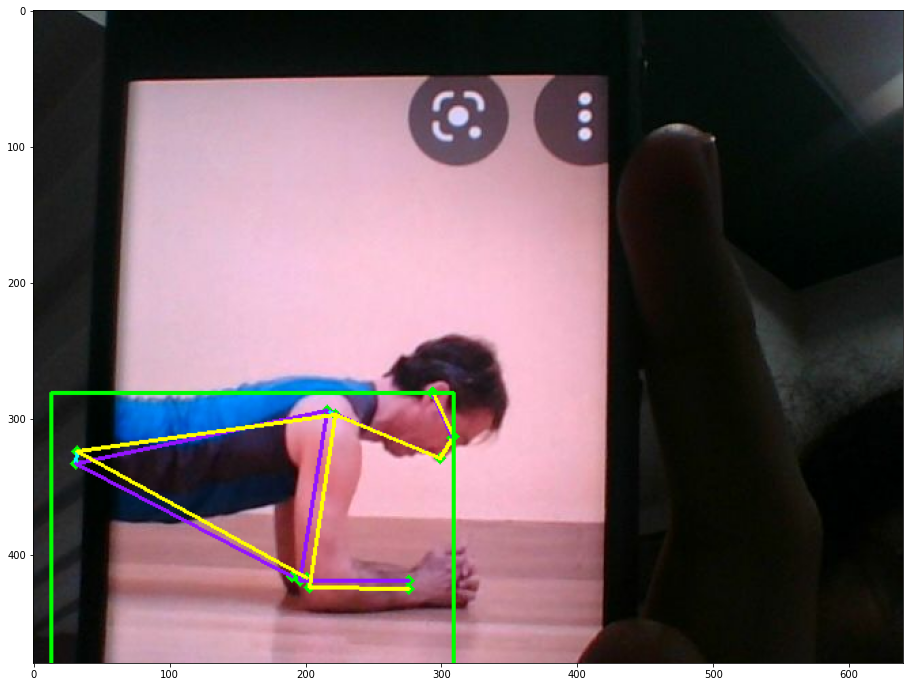

In [ ]:
if str(class_names[np.argmax(p)]) == 'downdog' or str(class_names[np.argmax(p)]) == 'goddess' or str(class_names[np.argmax(p)]) == 'plank' or str(class_names[np.argmax(p)]) == 'tree' or str(class_names[np.argmax(p)]) == 'warrior2':
  t = draw_prediction_on_image(image.numpy(), person, crop_region=None,close_figure=False, keep_input_size=True)

To make a live skeleton

In [ ]:
# return the image with a skeleton drawn on the human body
# copied from tensorflow movenets
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  # Draw the detection result on top of the image.
  image_np = utils.visualize(image, [person])

  # Plot the image with detection results.
  height, width, channel = image.shape
  aspect_ratio = float(width) / height

  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [ ]:
from IPython.display import display, Javascript, Image
from PIL import Image as Img
from PIL import ImageTk

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

In [ ]:
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# import torch
# from torchvision import transforms
# convert_tensor = transforms.ToTensor()
#   image = convert_tensor(img)


In [ ]:
import warnings
warnings.filterwarnings("ignore")
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0
predicted_class = ' '
bbox_array = np.zeros([480,640, 4], dtype=np.uint8)
while True:
  predicted_class = ' '
  bbox_array = np.zeros([480,640, 4], dtype=np.uint8)
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
      break

  # convert JS response to OpenCV Image
  image_arr = js_to_image(js_reply["img"])
  image_new = Img.fromarray(image_arr)
  image_new.save("filename.jpg")
  image_path = "filename.jpg"
  # try:
  image_new = tf.io.read_file(image_path)
  image_new = tf.io.decode_jpeg(image_new)
  # except:
  #   pass
  #   # print('Skipped ' + image_path + '. Invalid image.')
  # else:
  #   image = tf.io.read_file(image_path)
  #   image = tf.io.decode_jpeg(image)
  #   image_height, image_width, channel = image.shape

  # Skip images that isn't RGB because Movenet requires RGB images
  # if channel != 3:
    # print('Skipped ' + '. Image isn\'t in RGB format.')
  #  using detect function to make the skeleton of the person in the following image
  person = detect(image_new)
  detection_threshold = 0.6
  valid_image_count = 0
  count = 0
  # forming a dictionary of body parts with their corresponding coordinates
  body_parts = []
  body_coordinates = []
  i = 0
  for keypoints in person.keypoints:
      x_val = keypoints.coordinate.x
      y_val = keypoints.coordinate.y
      i = i+1
      pos = [x_val, y_val]
      a = str(keypoints[0])
      body_parts.append(str(a.split('.')[-1]))
      body_coordinates.append(pos)

  if len(body_parts) == 17:

    L1 = body_parts
    L2 = body_coordinates
    bp_coordinates = dict(zip(L1,L2))
    # bp_coordinates

    # forming an array of angles for every joint detected to add it to csv data
    body_angles = []
    parts = [['NOSE', 'NOSE' , 'NOSE'], ['LEFT_EYE', 'LEFT_EYE', 'LEFT_EYE'], ['RIGHT_EYE', 'RIGHT_EYE', 'RIGHT_EYE'], ['LEFT_EAR', 'LEFT_EAR', 'LEFT_EAR'], ['RIGHT_EAR', 'RIGHT_EAR', 'RIGHT_EAR'], ['LEFT_ELBOW', 'LEFT_SHOULDER', 'LEFT_HIP'], ['RIGHT_ELBOW', 'RIGHT_SHOULDER', 'RIGHT_HIP'], ['LEFT_WRIST', 'LEFT_ELBOW', 'LEFT_SHOULDER'], ['RIGHT_WRIST', 'RIGHT_ELBOW', 'RIGHT_SHOULDER'], ['LEFT_WRIST', 'LEFT_WRIST', 'LEFT_WRIST'], ['RIGHT_WRIST', 'RIGHT_WRIST', 'RIGHT_WRIST'], ['LEFT_SHOULDER', 'LEFT_HIP', 'LEFT_KNEE'], ['RIGHT_SHOULDER', 'RIGHT_HIP', 'RIGHT_KNEE'], ['LEFT_HIP', 'LEFT_KNEE', 'LEFT_ANKLE'], ['RIGHT_HIP', 'RIGHT_KNEE', 'RIGHT_ANKLE'], ['LEFT_ANKLE', 'LEFT_ANKLE', 'LEFT_ANKLE'], ['RIGHT_ANKLE', 'RIGHT_ANKLE', 'RIGHT_ANKLE']]
    for pts in parts:
        part_1 = bp_coordinates[pts[0]]
        part_2 = bp_coordinates[pts[1]]
        part_3 = bp_coordinates[pts[2]]
        body_angles.append(cal_angle(part_1, part_2, part_3))

    # Save landmarks if all landmarks were detected
    # saving the landmarks that have detection score greater than the set threshold
    landmark_score = [keypoint.score for keypoint in person.keypoints]
    for i in range(17):
      if landmark_score[i] > 0.5:
        count = count + 1
    # if not should_keep_image:
      # print('Skipped ' +'. No pose was confidentlly detected.')

    if count > 13:
      # Draw the prediction result on top of the image for debugging later
      # Drawing the landmarks on the image that satisfy the threshold factor by using the above function
      output_overlay = draw_prediction_on_image(image_new.numpy().astype(np.uint8), person, close_figure=True, keep_input_size=True)

      # converting RGB to BGR so that it can be used in opencv
      output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)

      # Get landmarks and scale it to the same size as the input image
      # [x, y, score]  for every landmark
      pose_landmarks = np.array([[keypoint.coordinate.x, keypoint.coordinate.y, body_angles[index], keypoint.score,] for index, keypoint in enumerate(person.keypoints)], dtype=np.float32)

      # saving the coordinates with the image nape in csv file
      coordinates = pose_landmarks.flatten().astype(np.str).tolist()

      input = pose_landmarks.reshape(1, 68)
      input_df = pd. DataFrame(input, columns=['NOSE_x', 'NOSE_y', 'NOSE_score', 'LEFT_EYE_x', 'LEFT_EYE_y', 'LEFT_EYE_score', 'RIGHT_EYE_x', 'RIGHT_EYE_y', 'RIGHT_EYE_score', 'LEFT_EAR_x', 'LEFT_EAR_y', 'LEFT_EAR_score', 'RIGHT_EAR_x', 'RIGHT_EAR_y', 'RIGHT_EAR_score', 'LEFT_SHOULDER_x', 'LEFT_SHOULDER_y', 'LEFT_SHOULDER_score', 'RIGHT_SHOULDER_x', 'RIGHT_SHOULDER_y', 'RIGHT_SHOULDER_score', 'LEFT_ELBOW_x', 'LEFT_ELBOW_y', 'LEFT_ELBOW_score', 'RIGHT_ELBOW_x', 'RIGHT_ELBOW_y', 'RIGHT_ELBOW_score', 'LEFT_WRIST_x', 'LEFT_WRIST_y', 'LEFT_WRIST_score', 'RIGHT_WRIST_x', 'RIGHT_WRIST_y', 'RIGHT_WRIST_score', 'LEFT_HIP_x', 'LEFT_HIP_y', 'LEFT_HIP_score', 'RIGHT_HIP_x', 'RIGHT_HIP_y', 'RIGHT_HIP_score', 'LEFT_KNEE_x', 'LEFT_KNEE_y', 'LEFT_KNEE_score', 'RIGHT_KNEE_x', 'RIGHT_KNEE_y', 'RIGHT_KNEE_score', 'LEFT_ANKLE_x', 'LEFT_ANKLE_y', 'LEFT_ANKLE_score', 'RIGHT_ANKLE_x', 'RIGHT_ANKLE_y', 'RIGHT_ANKLE_score', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68'])

      predicted_class = str(class_names[np.argmax(yoga_pose_model.predict(input_df))])
      # print(predicted_class)
      if predicted_class == 'downdog' or predicted_class == 'goddess' or predicted_class == 'plank' or predicted_class == 'warrior2':
        # create transparent overlay for bounding box
        bbox_array = np.zeros([480,640, 4], dtype=np.uint8)
        t = draw_prediction_on_image(bbox_array, person, crop_region=None,close_figure=False, keep_input_size=True)
        bbox_array = cv2.putText(bbox_array, f'POSE:{predicted_class}', (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)

  bbox_array[:,:,3] = (bbox_array.max(axis =2) > 0 ).astype(int) * 255
  # convert overlay of bbox into bytes
  bbox_bytes = bbox_to_bytes(bbox_array)
  # update bbox so next frame gets new overlay
  bbox = bbox_bytes;

<IPython.core.display.Javascript object>